In [89]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST
import pytorch_lightning as pl
import torchmetrics
import pandas as pd
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from dtreeviz.trees import dtreeviz

ImportError: cannot import name 'dtreeviz' from 'dtreeviz.trees' (c:\code\ExAI\exai\lib\site-packages\dtreeviz\trees.py)

In [3]:
SEED = 2024
pl.seed_everything(SEED)

Seed set to 2024


2024

## Utils

In [12]:
LEARING_RATE = 1e-3
BATCH_SIZE = 64
EPOCHS = 5
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {DEVICE}')

Using cuda


In [23]:
def correlation_matrix(df, title):
    corr = df.corr()
    mask = np.triu(np.ones_like(corr, dtype=bool))
    plt.figure(figsize=(20, 10))
    sns.heatmap(corr, mask=mask, annot=False, cmap='coolwarm', vmin=0, vmax=1)
    plt.title(title)
    plt.show()

In [4]:
def load_data(batch_size=BATCH_SIZE, num_workers=4):
    # Transformaciones para los datos
    transform = transforms.ToTensor()

    # Carga de datos de entrenamiento
    mnist_train = MNIST(os.getcwd(), train=True, download=True, transform=transform)
    
    # División entre entrenamiento y validación
    train_size = int(0.8 * len(mnist_train))
    val_size = len(mnist_train) - train_size
    mnist_train, mnist_val = random_split(mnist_train, [train_size, val_size])

    # DataLoader para entrenamiento y validación
    train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers, shuffle=True, persistent_workers=True)
    val_loader = DataLoader(mnist_val, batch_size=batch_size, num_workers=num_workers, shuffle=False, persistent_workers=True)

    # Carga de datos de test
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers, persistent_workers=True)

    return train_loader, val_loader, test_loader

train_loader, val_loader, test_loader = load_data()

100%|██████████| 9912422/9912422 [00:00<00:00, 14041507.86it/s]


Extracting c:\code\ExAI\MNIST\raw\train-images-idx3-ubyte.gz to c:\code\ExAI\MNIST\raw



100%|██████████| 28881/28881 [00:00<00:00, 28800688.02it/s]


Extracting c:\code\ExAI\MNIST\raw\train-labels-idx1-ubyte.gz to c:\code\ExAI\MNIST\raw



100%|██████████| 1648877/1648877 [00:00<00:00, 3240436.27it/s]


Extracting c:\code\ExAI\MNIST\raw\t10k-images-idx3-ubyte.gz to c:\code\ExAI\MNIST\raw



100%|██████████| 4542/4542 [00:00<?, ?it/s]

Extracting c:\code\ExAI\MNIST\raw\t10k-labels-idx1-ubyte.gz to c:\code\ExAI\MNIST\raw



In [5]:

class MNISTModel(pl.LightningModule):
    def __init__(self, num_classes=10, lr=1e-3):
        super(MNISTModel, self).__init__()
        self.layer_1 = nn.Linear(28 * 28, 128)
        self.layer_2 = nn.Linear(128, 256)
        self.layer_3 = nn.Linear(256, 10)
        self.lr = lr
        self.num_classes = num_classes
        
        # metrics
        self.train_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.val_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.test_acc = torchmetrics.Accuracy(num_classes=self.num_classes, task='multiclass')
        self.precision = torchmetrics.Precision(num_classes=self.num_classes, average='macro', task='multiclass')
        self.recall = torchmetrics.Recall(num_classes=self.num_classes, average='macro', task='multiclass')
        self.f1 = torchmetrics.F1Score(num_classes=self.num_classes, average='macro', task='multiclass')

    def forward(self, x, record_activations=False):
        x = x.view(x.size(0), -1)
        x = self.layer_1(x)
        x_layer1 = F.relu(x)

        x = self.layer_2(x_layer1)
        x_layer2 = F.relu(x)

        x = self.layer_3(x_layer2)
        x_layer3 = F.log_softmax(x, dim=1)

        if record_activations:
            return x_layer3, [x_layer1, x_layer2, x_layer3]

        return x_layer3
    
    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', self.train_acc(logits, y), prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', self.val_acc(logits, y), prog_bar=True)

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', self.test_acc(logits, y), prog_bar=True)
        self.log('precision', self.precision(logits, y), prog_bar=True)
        self.log('recall', self.recall(logits, y), prog_bar=True)
        self.log('f1', self.f1(logits, y), prog_bar=True)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
model = MNISTModel(lr=LEARING_RATE)

## Train

In [6]:
trainer = pl.Trainer(max_epochs=EPOCHS)
trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Missing logger folder: c:\code\ExAI\lightning_logs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                | Params
--------------------------------------------------
0 | layer_1   | Linear              | 100 K 
1 | layer_2   | Linear              | 33.0 K
2 | layer_3   | Linear              | 2.6 K 
3 | train_acc | MulticlassAccuracy  | 0     
4 | val_acc   | MulticlassAccuracy  | 0     
5 | test_acc  | MulticlassAccuracy  | 0     
6 | precision

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


In [7]:
trainer.test(model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3060 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│            f1             │    0.9688427448272705     │
│         precision         │    0.9722179770469666     │
│          recall           │    0.9713566303253174     │
│         test_acc          │    0.9731000065803528     │
│         test_loss         │    0.08862943947315216    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.08862943947315216,
  'test_acc': 0.9731000065803528,
  'precision': 0.9722179770469666,
  'recall': 0.9713566303253174,
  'f1': 0.9688427448272705}]

## Activations

In [8]:
def load_data_for_activations():
    # load only one image of the test set
    transform = transforms.ToTensor()
    mnist_test = MNIST(os.getcwd(), train=False, download=True, transform=transform)
    test_loader = DataLoader(mnist_test, batch_size=1, shuffle=False)
    return test_loader

test_loader_act = load_data_for_activations()

In [9]:
model_for_act = MNISTModel.load_from_checkpoint('lightning_logs/version_0/checkpoints/epoch=4-step=3750.ckpt')
model_for_act.eval()

MNISTModel(
  (layer_1): Linear(in_features=784, out_features=128, bias=True)
  (layer_2): Linear(in_features=128, out_features=256, bias=True)
  (layer_3): Linear(in_features=256, out_features=10, bias=True)
  (train_acc): MulticlassAccuracy()
  (val_acc): MulticlassAccuracy()
  (test_acc): MulticlassAccuracy()
  (precision): MulticlassPrecision()
  (recall): MulticlassRecall()
  (f1): MulticlassF1Score()
)

In [19]:
# Número de neuronas en cada capa
layer1_neurons = 128 
layer2_neurons = 256 
layer3_neurons = 10 

# Creación de las columnas para cada neurona
columns = ['Number']
columns += [f'Layer1_Neuron{i+1}' for i in range(layer1_neurons)]
columns += [f'Layer2_Neuron{i+1}' for i in range(layer2_neurons)]
columns += [f'Layer3_Neuron{i+1}' for i in range(layer3_neurons)]

# Estimación del tamaño del DataFrame (ajusta según tu conjunto de datos)
num_rows = len(test_loader_act) 

# Pre-creación del DataFrame
df = pd.DataFrame(index=range(num_rows), columns=columns)

# Llenar el DataFrame
for idx, batch in enumerate(tqdm(test_loader_act, desc='Running activations')):
    x, y = batch
    _, r = model_for_act(x, record_activations=True)

    # Construir fila para el DataFrame
    row = {'Number': y.item()}
    row.update({f'Layer1_Neuron{i+1}': r[0].cpu().detach().numpy()[0, i] for i in range(layer1_neurons)})
    row.update({f'Layer2_Neuron{i+1}': r[1].cpu().detach().numpy()[0, i] for i in range(layer2_neurons)})
    row.update({f'Layer3_Neuron{i+1}': r[2].cpu().detach().numpy()[0, i] for i in range(layer3_neurons)})

    df.loc[idx] = row

Running activations: 100%|██████████| 10000/10000 [00:23<00:00, 417.17it/s]


In [20]:
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.740439,0.0,0.0,0.0,0.0,0.0,0.196717,0.0,0.0,...,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.01362,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,0.0,0.0,2.195834,2.045902,0.488143,1.100444,1.067014,0.169285,1.632867,...,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,0.0,1.838184,0.470426,0.2989,0.0,0.16031,1.212221,0.0,0.665693,...,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,0.0,0.0,0.0,0.0,1.68934,0.451246,0.0,2.347926,2.136712,...,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.45652
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.782253,2.228824,...,-11.6886,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


In [21]:
# save activations csv
df.to_csv('activations.csv', index=False)

## Study activation

In [4]:
# read activations csv
folder = os.path.join(os.getcwd(), 'activations', 'activations.csv')
df = pd.read_csv(folder)
df.head()

,Number,Layer1_Neuron1,Layer1_Neuron2,Layer1_Neuron3,Layer1_Neuron4,Layer1_Neuron5,Layer1_Neuron6,Layer1_Neuron7,Layer1_Neuron8,Layer1_Neuron9,...,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,0.740439,0.000000,0.000000,0.000000,0.000000,0.000000,0.196717,0.000000,0.000000,...,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.013620,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,0.000000,0.000000,2.195834,2.045902,0.488143,1.100444,1.067014,0.169285,1.632867,...,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,0.000000,1.838184,0.470426,0.298900,0.000000,0.160310,1.212221,0.000000,0.665693,...,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,0.000000,0.000000,0.000000,0.000000,1.689340,0.451246,0.000000,2.347926,2.136712,...,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.456520
4,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.782253,2.228824,...,-11.688600,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


In [35]:
def get_layer_columns(layer):
    layer_columns = ['Number']
    layer_columns += [c for c in df.columns if layer in c]
    return layer_columns

# create new dataframe
df_layer1 = df[get_layer_columns('Layer1')]
df_layer1.head()

# create new dataframe
df_layer2 = df[get_layer_columns('Layer2')]
df_layer2.head()

# create new dataframe
df_layer3 = df[get_layer_columns('Layer3')]
df_layer3.head()

,Number,Layer3_Neuron1,Layer3_Neuron2,Layer3_Neuron3,Layer3_Neuron4,Layer3_Neuron5,Layer3_Neuron6,Layer3_Neuron7,Layer3_Neuron8,Layer3_Neuron9,Layer3_Neuron10
0,7.0,-14.269825,-15.120548,-11.913773,-8.569132,-21.354063,-15.013620,-28.098251,-0.000271,-17.068691,-9.522126
1,2.0,-19.033363,-8.803956,-0.000152,-13.276193,-21.732006,-18.949306,-18.809565,-19.291412,-14.914445,-28.465996
2,1.0,-14.493092,-0.001562,-8.042879,-11.653164,-9.503178,-12.153508,-8.864405,-7.786788,-7.428865,-14.997212
3,0.0,-0.000011,-18.471863,-11.829388,-19.525738,-19.773577,-15.946034,-12.615609,-15.834463,-19.109869,-15.456520
4,4.0,-11.688600,-14.611605,-11.004838,-15.316495,-0.007348,-11.887294,-12.292017,-9.257276,-12.816794,-4.935619


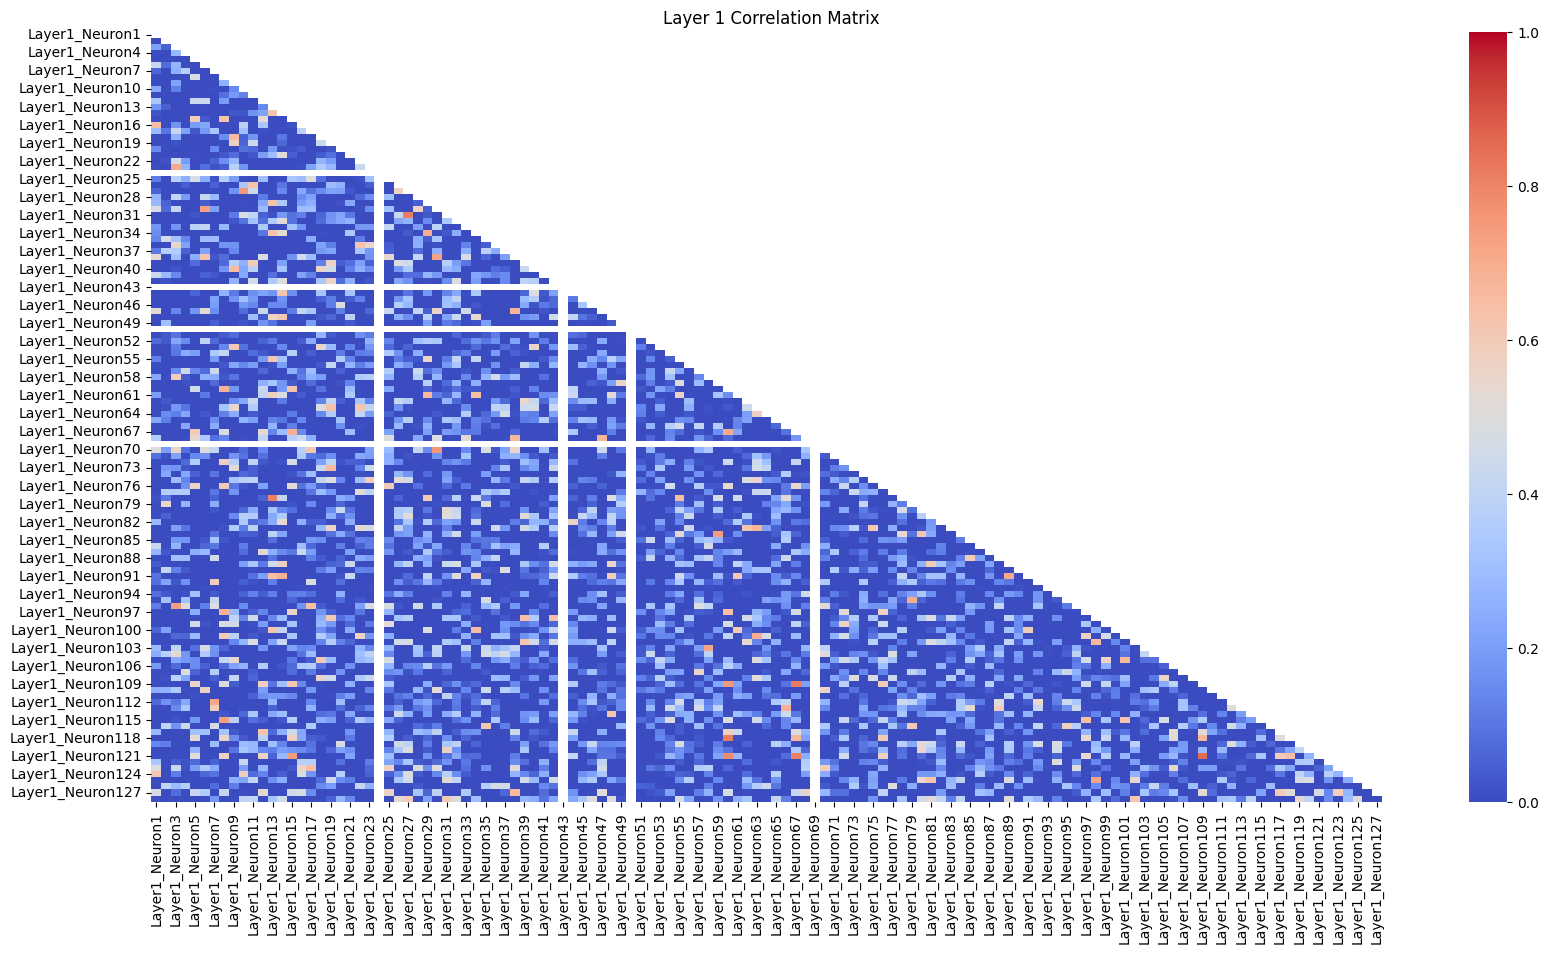

In [24]:
# plot correlation matrix
df_layer1_not_number = df_layer1.drop(columns=['Number'])
correlation_matrix(df_layer1_not_number, 'Layer 1 Correlation Matrix')


### IoU of activations

In [67]:
def IoU(data, num_classes=10, threshold = 0.1):
    activation = data.copy()
    # Binarizar las activaciones
    activation = activation.gt(threshold).astype(bool)
    results = []
    for num1 in range(num_classes):
        for num2 in range(num1 + 1, num_classes):
            # Seleccionar las filas correspondientes para cada número
            df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
            df_layer1_num2_binary = activation[df_layer1['Number'] == num2]

            # Calcular la intersección y la unión
            intersection = df_layer1_num1_binary & df_layer1_num2_binary
            union = df_layer1_num1_binary | df_layer1_num2_binary

            # Calcular el IoU, con manejo de división por cero
            iou = intersection.sum().sum() / union.sum().sum() if union.sum().sum() != 0 else 0

            results.append({'Number1': num1, 'Number2': num2, 'IoU': iou})
    return pd.DataFrame(results)

In [58]:
threshold = 0.1
# Convertir todo el DataFrame a binario de una vez
df_layer1_binary = df_layer1.gt(threshold).astype(bool)
df_iou_layer1 = IoU(df_layer1_binary)

df_layer2_binary = df_layer2.gt(threshold).astype(bool)
df_iou_layer2 = IoU(df_layer2_binary)

In [59]:
# get row that IoU > 0
df_iou_layer1[df_iou_layer1['IoU'] > 0]

,Number1,Number2,IoU


In [60]:
df_iou_layer2[df_iou_layer2['IoU'] > 0]

,Number1,Number2,IoU


### Mean and std of activations

In [15]:
def plot_meand_and_std(df: pd.DataFrame, title: str, numbers: list = None) -> None:
    if not numbers:
        assert 'You must provide at least one number'

    # two loop over numbers without repetitions

    for num1 in numbers:
        for num2 in numbers:
            if num1 >= num2:
                continue

            # select rows for each number
            df_num1 = df[df['Number'] == num1]
            df_num2 = df[df['Number'] == num2]

            # calculate mean and std
            mean_num1 = df_num1.mean()
            std_num1 = df_num1.std()
            mean_num2 = df_num2.mean()
            std_num2 = df_num2.std()

            neuron_index = range(1, len(mean_num1) + 1)

            # plot mean and std
            plt.figure(figsize=(20, 10))
            plt.plot(neuron_index, mean_num1.values, label=f'Number {num1}')
            plt.fill_between(neuron_index, mean_num1 - std_num1, mean_num1 + std_num1, alpha=0.2)

            plt.plot(neuron_index, mean_num2.values, label=f'Number {num2}')
            plt.fill_between(neuron_index, mean_num2 - std_num2, mean_num2 + std_num2, alpha=0.2)

            plt.title(title)
            plt.legend()
            plt.show()
    

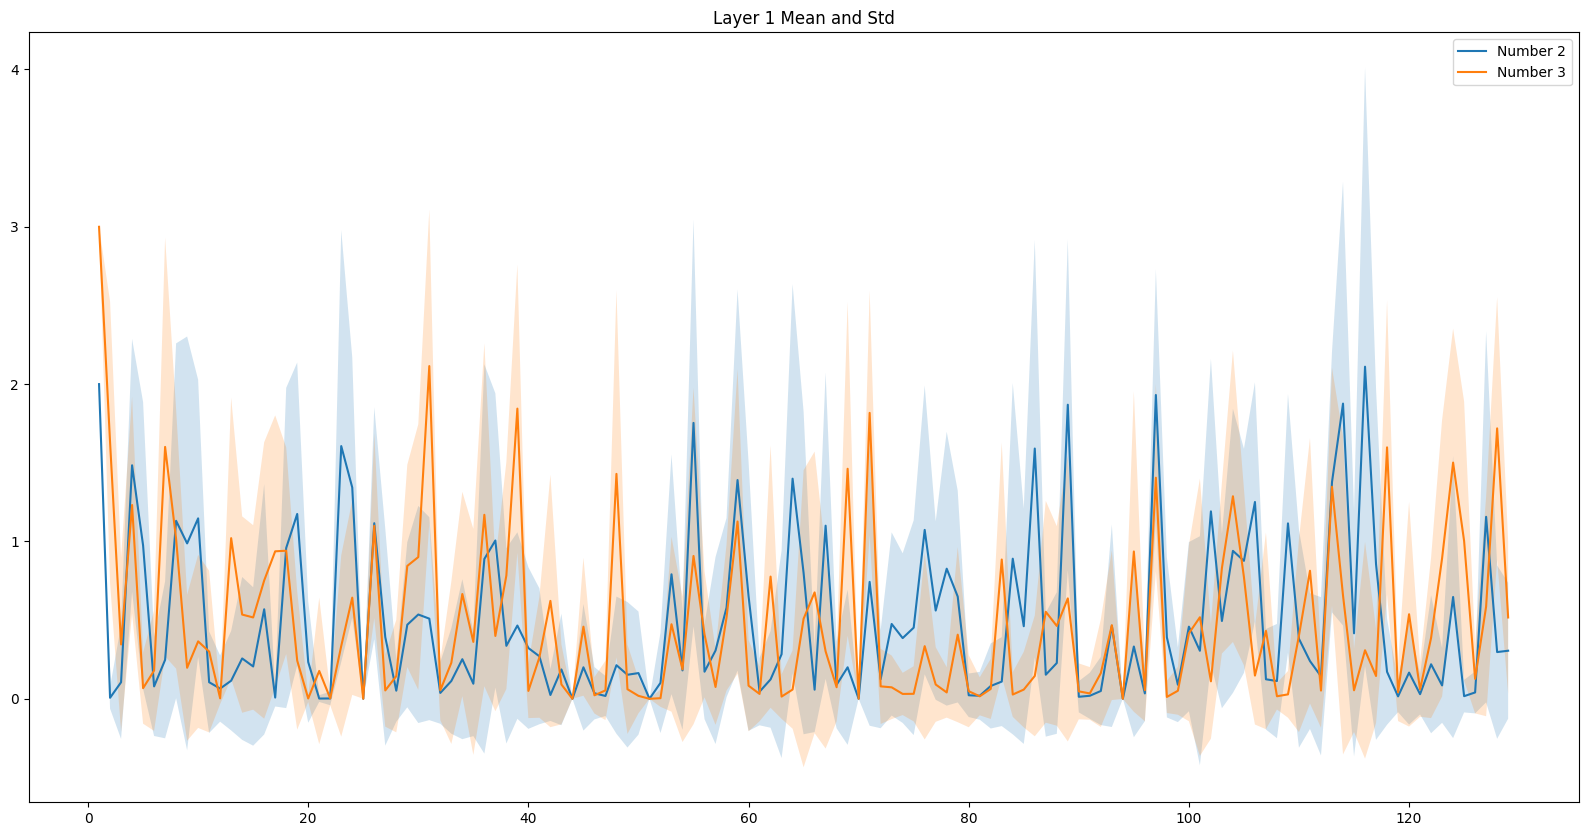

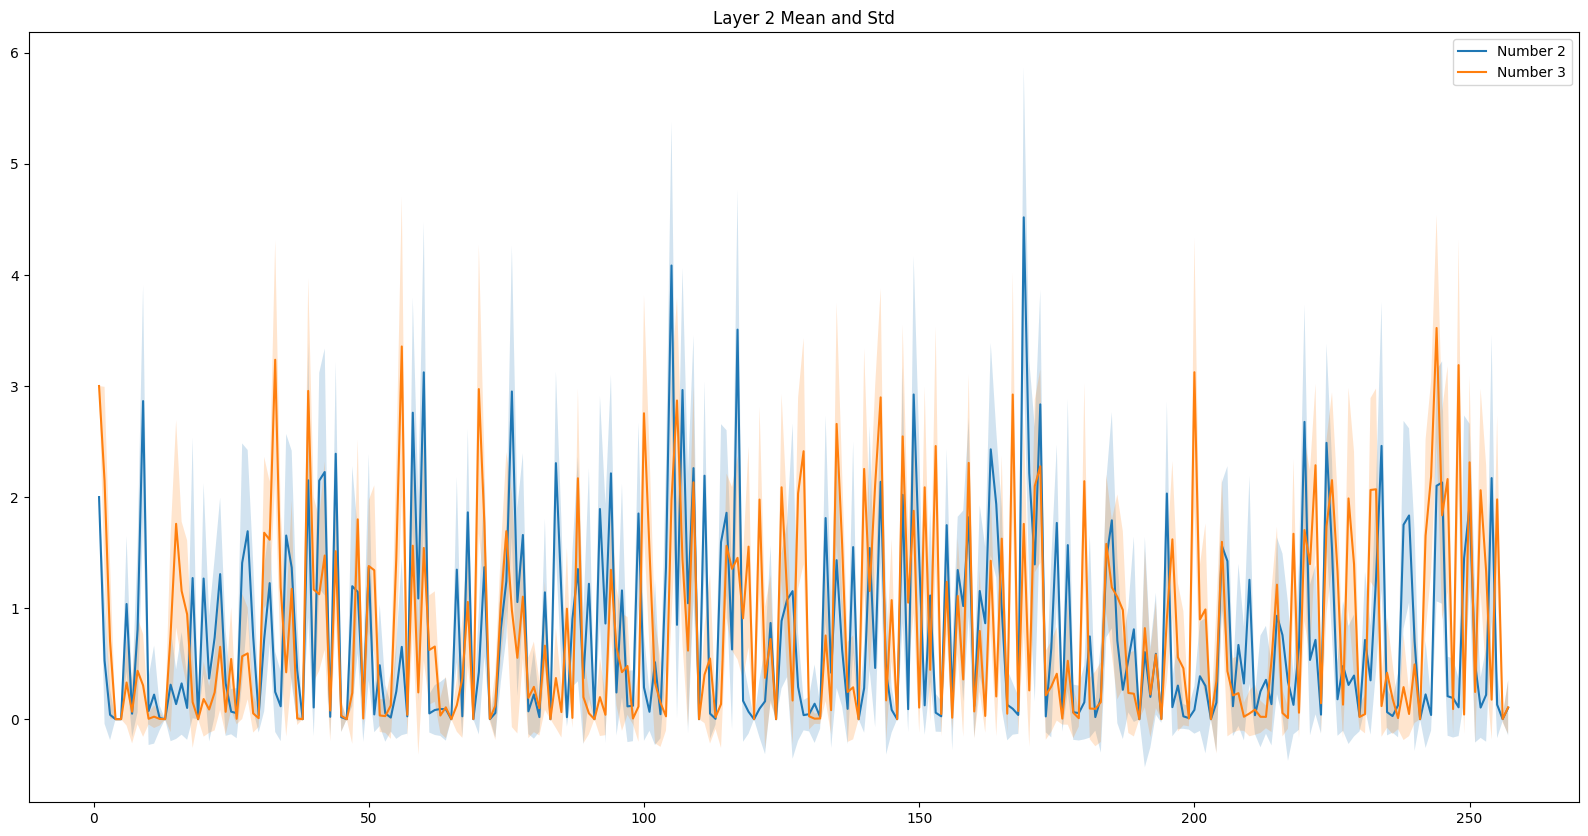

In [25]:
numbers = [3, 2]
plot_meand_and_std(df_layer1, 'Layer 1 Mean and Std', numbers=numbers)
plot_meand_and_std(df_layer2, 'Layer 2 Mean and Std', numbers=numbers)

### Iou for quantiles

In [63]:
def divide_data_by_quartiles(data):
    # Calcula los cuartiles para cada neurona, excluyendo la columna 'Number'
    quartiles = data.drop(columns=['Number']).quantile([0.25, 0.5, 0.75])

    # Función interna para clasificar cada muestra
    def classify_sample(row):
        low, mid_low, mid_high, high = 0, 0, 0, 0
        for neuron, value in row.items():
            if value <= quartiles[neuron][0.25]:
                low += 1
            elif value <= quartiles[neuron][0.5]:
                mid_low += 1
            elif value <= quartiles[neuron][0.75]:
                mid_high += 1
            else:
                high += 1

        max_count = max(low, mid_low, mid_high, high)
        if max_count == low:
            return 'low'
        elif max_count == mid_low:
            return 'mid_low'
        elif max_count == mid_high:
            return 'mid_high'
        else:
            return 'high'

    # Aplica la clasificación a cada fila
    data_by_quartiles = data.drop(columns=['Number']).copy()
    data_by_quartiles['IQR_Class'] = data_by_quartiles.apply(classify_sample, axis=1)
    data_by_quartiles['Number'] = data['Number']

    return data_by_quartiles

def generate_df_by_quartiles(data: pd.DataFrame) -> dict:
    
    data_low = data[data['IQR_Class'] == 'low']
    data_mid_low = data[data['IQR_Class'] == 'mid_low']
    data_mid_high = data[data['IQR_Class'] == 'mid_high']
    data_high = data[data['IQR_Class'] == 'high']

    return {
        'low': data_low,
        'mid_low': data_mid_low,
        'mid_high': data_mid_high,
        'high': data_high
    }





In [60]:
df_layer1_by_quartiles = divide_data_by_quartiles(df_layer1)

In [61]:
df_layer1_by_quartiles['IQR_Class'].value_counts()

IQR_Class
low    10000
Name: count, dtype: int64

In [62]:
df_layer2_by_quartiles = divide_data_by_quartiles(df_layer2)
df_layer2_by_quartiles['IQR_Class'].value_counts()

IQR_Class
low         9941
mid_high      58
mid_low        1
Name: count, dtype: int64

In [70]:
df_layer2_by_quartiles_low = df_layer2_by_quartiles[df_layer2_by_quartiles['IQR_Class'] == 'low']
df_layer2_by_quartiles_low_IoU = IoU(df_layer2_by_quartiles_low.drop(columns=['IQR_Class', 'Number']))
df_layer2_by_quartiles_low_IoU['IoU'].value_counts()


C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_laye

IoU
0.0    45
Name: count, dtype: int64

In [73]:
df_layer2_by_quartiles_mid_high = df_layer2_by_quartiles[df_layer2_by_quartiles['IQR_Class'] == 'mid_high']
df_layer2_by_quartiles_mid_high_IoU = IoU(df_layer2_by_quartiles_mid_high.drop(columns=['IQR_Class', 'Number']))
df_layer2_by_quartiles_mid_high_IoU['IoU'].value_counts()

C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num1_binary = activation[df_layer1['Number'] == num1]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_layer1_num2_binary = activation[df_layer1['Number'] == num2]
C:\Users\Usuario\AppData\Local\Temp\ipykernel_24200\2639852781.py:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_laye

IoU
0.0    45
Name: count, dtype: int64

In [64]:
df_layer3_by_quartiles = divide_data_by_quartiles(df_layer3)
df_layer3_by_quartiles['IQR_Class'].value_counts()

IQR_Class
low         3433
mid_low     2446
mid_high    2398
high        1723
Name: count, dtype: int64

## Clf for activations

In [85]:
def train_decision_tree(X, y, test_size=0.3, max_depth=3):
    # Dividir los datos en conjuntos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

    # Entrenar el modelo
    model = DecisionTreeClassifier(max_depth=max_depth)
    model.fit(X_train, y_train)

    # Evaluar el modelo en el conjunto de prueba
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred)

    return model, report

def visualize_decision_tree(model, feature_names, class_names):

    plt.figure(figsize=(20,10))
    plot_tree(model, filled=True, feature_names=feature_names, class_names=class_names)
    # save tree
    plt.savefig('tree.png')
    plt.show()


In [81]:
X = df_layer1.drop(columns=['Number'])
y = df_layer1['Number']

model, report = train_decision_tree(X, y, max_depth=10)
print(report)

              precision    recall  f1-score   support

         0.0       0.94      0.93      0.93       307
         1.0       0.96      0.95      0.95       335
         2.0       0.83      0.91      0.87       302
         3.0       0.87      0.91      0.89       301
         4.0       0.90      0.83      0.86       284
         5.0       0.83      0.82      0.82       285
         6.0       0.94      0.85      0.89       302
         7.0       0.91      0.86      0.88       290
         8.0       0.84      0.85      0.84       281
         9.0       0.80      0.88      0.84       313

    accuracy                           0.88      3000
   macro avg       0.88      0.88      0.88      3000
weighted avg       0.88      0.88      0.88      3000



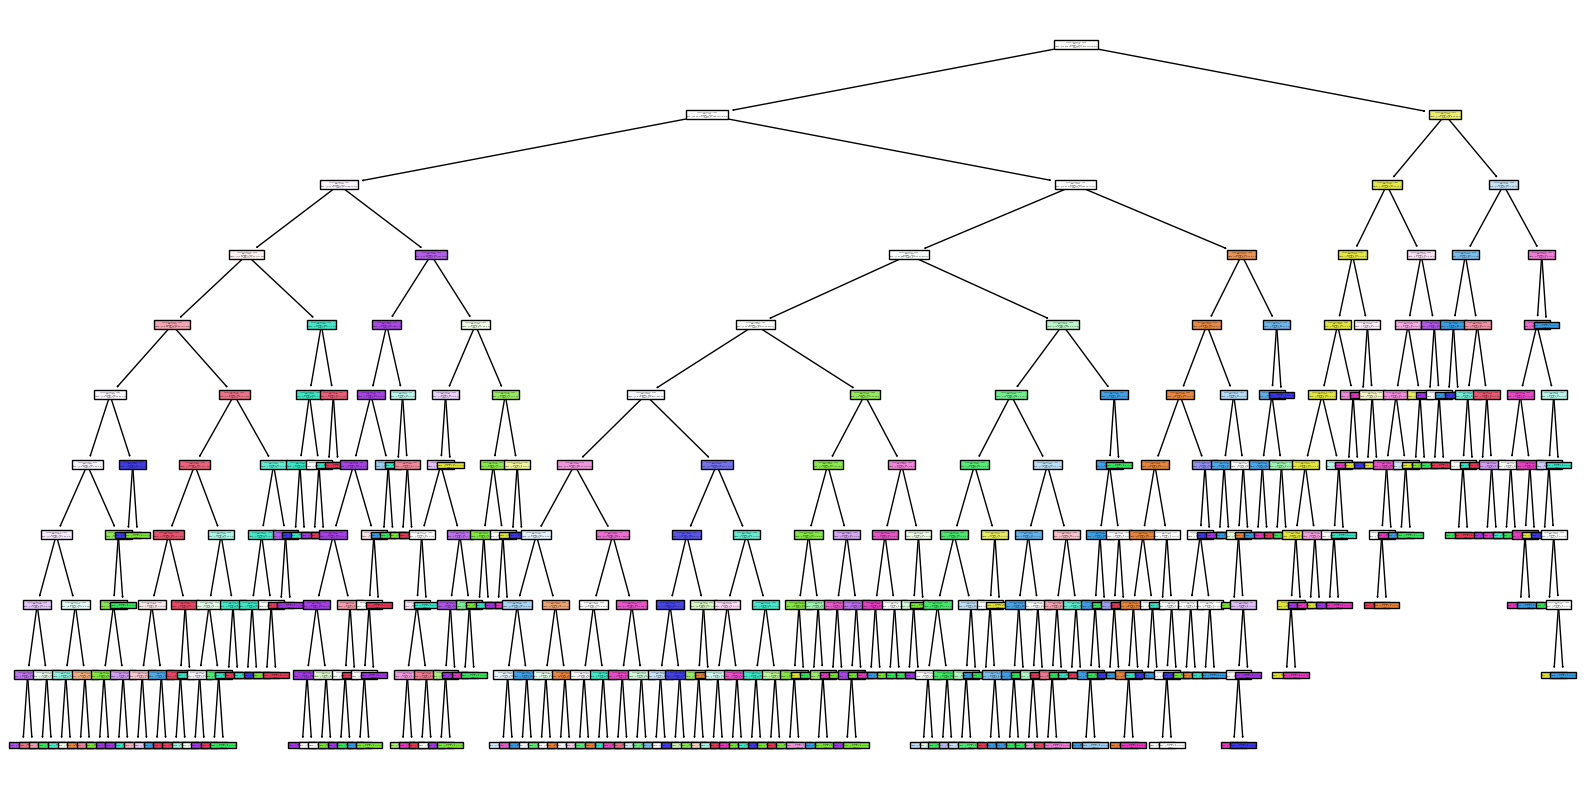

In [86]:
visualize_decision_tree(model, X.columns, [str(i) for i in range(10)])